In [1]:
pip install music21

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import music21
import os
from music21 import *

In [3]:
us=music21.environment.UserSettings()
us.restoreDefaults()

In [4]:
#Setting environnement

#Morgan (Windows)
# music21.environment.set('musescoreDirectPNGPath',str(os.path.join("C:\\", "Program Files","MuseScore 4","bin","MuseScore4.exe")))
# music21.environment.set('musicxmlPath', str(os.path.join("C:\\", "Program Files","MuseScore 4","bin","MuseScore4.exe")))
# music21.environment.set('lilypondPath', r'C:\Users\jeffs\lilypond-2.24.2\bin\lilypond.exe')

#Anais (Linux)
lilypond_path = '/anaconda3/lib/python3.10/site-packages/lilypond-binaries/bin/lilypond'
full_path = os.path.expanduser(f'~{lilypond_path}')
music21.environment.set('lilypondPath', full_path)


In [5]:
def XML_to_MIDI(file, output_folder,i):
    '''Conversion avec affichage du numero du fichier'''
    
    filename = os.path.splitext(os.path.basename(file))[0]
    musicxml_stream = music21.converter.parse(file,format='musicxml')
    midi_stream=stream.Stream()
    for element in musicxml_stream.flat:
        midi_stream.append(element)
    midi_filename = os.path.join(output_folder, f"{i}_{filename}.midi")
    midi_stream.write('midi', fp=midi_filename)
    print(f"{i} : Fichier MIDI créé : {midi_filename}"+20*" ",end='\r') 

def open_all_xml(folder,x):
    '''Retourne la liste des X premiers objets music21.bases.scores
    du folder contenant des fichiers XML'''
    streams=[]
    for i,file in enumerate(os.listdir(folder)[:x]) :
        if 'checkpoint' not in file:
            s=music21.converter.parse(folder+"/"+file)
            streams.append(s)
            print(i+1, "fichiers XML charges"+20*" ",end='\r')
    print(100*" ") 
    print("Chargement termine")
    return streams



In [6]:
streams=open_all_xml("data_xml",20)

                                                                                                    
Chargement termine


In [7]:
n=0

Camundongo
<class 'music21.stream.base.Score'>


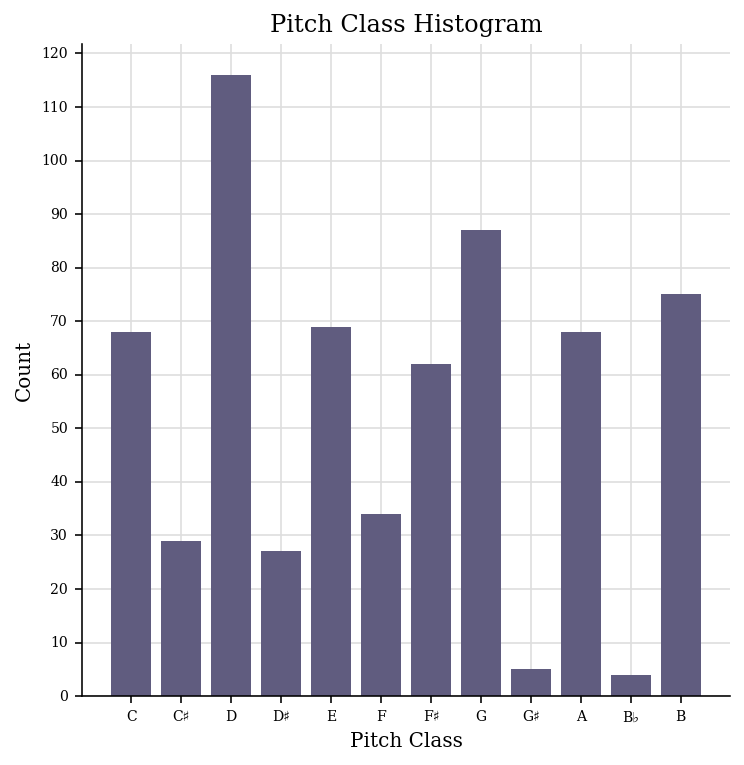

In [8]:
print(streams[n].metadata.title)
print(type(streams[n]))
streams[n].plot('histogram', 'pitchClass', 'count')

In [9]:
streams[4].show('text')

{0.0} <music21.text.TextBox 'REMEXENDO'>
{0.0} <music21.text.TextBox 'Radamés Gn...'>
{0.0} <music21.text.TextBox 'Aldo Guina...'>
{0.0} <music21.metadata.Metadata object at 0x7f6c270d99c0>
{0.0} <music21.stream.Part P1>
    {0.0} <music21.instrument.Instrument 'P1: P1: '>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.layout.PageLayout>
        {0.0} <music21.layout.SystemLayout>
        {0.0} <music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of D major>
        {0.0} <music21.meter.TimeSignature 2/4>
        {0.0} <music21.note.Rest quarter>
        {1.0} <music21.note.Rest 16th>
        {1.25} <music21.note.Note A>
        {1.5} <music21.note.Note A->
        {1.75} <music21.note.Note G>
    {0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 17 offset=32.0>>
    {0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Measure 18 offset=34.

In [10]:
print({'A' : 'La' , 'B' : 'Si' , 'C': 'Do' , 'D' : 'Ré', 'E' : 'Mi' , 'F' : 'Fa' , 'G' : 'Sol' } )

{'A': 'La', 'B': 'Si', 'C': 'Do', 'D': 'Ré', 'E': 'Mi', 'F': 'Fa', 'G': 'Sol'}


In [17]:
def get_measure_indices_for_rehearsal_marks(score):
    '''Retourne les numero de mesures pour lequels la partition possede des RehearsalMark'''
    rehearsal_marks = score.recurse().getElementsByClass('RehearsalMark')
    measure_indices = []
    for mark in rehearsal_marks:
        mark_text = str(mark)
        measure = mark.getContextByClass('Measure')
        if measure:
            measure_index = measure.number
            measure_indices.append((str(mark), measure_index))
    
    return measure_indices

def get_time_signature(score):
    '''Retourne la signature du temps de la partition en str sinon une str vide'''
    time_signature = None
    for element in score.flat:
        if isinstance(element, meter.TimeSignature):
            time_signature = element
            break
    if time_signature:
        time_signature_name = time_signature.ratioString
        return time_signature_name
    else:
        return ''
    
def get_keys(score):
    '''Retourne la liste des clés de la partition'''
    keys=[]
    for element in score.flat:
        if isinstance(element, key.KeySignature):
            keys.append(element)
    return keys



def get_number_of_measures(score):
    '''Retourne le nombre de mesure de la partition'''
    last_measure = None
    for element in score.recurse():
        if isinstance(element, stream.Measure):
            last_measure = element

    if last_measure:
        return last_measure.number
    else:
        return 0  # Aucune mesure trouvée

def extract_notes(score):
    '''Retourne un dic { measure : liste de notes }'''
    notes_dic=dict()
    for part in score.parts:
        m = 0
        for measure in part.getElementsByClass(stream.Measure):
            m += 1
            notes = measure.getElementsByClass(music21.note.Note)
            if notes:
                notes_dic[m] = [ n.nameWithOctave for n in notes]

    return notes_dic

def extract_chord_symbols(score):
    '''retourne un dic { num_measure : liste accord}'''
    chord_symbols_dict = {}
    for part in score.parts:
        m = 0
        for measure in part.getElementsByClass(stream.Measure):
            m += 1
            d=[] #duree locale
            ds=[] #durees globales
            chords=[]
            
            for element in measure.flat:
                if isinstance(element,harmony.ChordSymbol):
                    chords.append(element.figure)
                    if d!=[]:
                        ds.append(sum(d))
                    d=[]
                if isinstance(element,music21.note.Note) : #l'expression locale est terminee
                    d.append(float(element.duration.quarterLength))
                    
            if d!=[]:
                 ds.append(sum(d))
            if chords:
                chord_symbols_dict[m] = [ (c,d) for c,d in zip(chords,ds)]
            
            

    return chord_symbols_dict

def get_marks_repeat(score):
    '''retourne les indices des differente marque de repetition'''
    dic=dict()
    segno_mark=[]
    coda_mark=[]
    repeat_direct_left=[]
    repeat_direct_right=[]
    key_change=[]
    for part in score.parts:
        m = 0
        for measure in part.getElementsByClass(stream.Measure):
            for element in measure.flat:
                if isinstance(element,music21.repeat.Segno):
                    segno_mark.append(measure.number)
                if isinstance(element,music21.repeat.Coda):
                    coda_mark.append(measure.number)
                if isinstance(element,music21.key.KeySignature):
                    key_change.append(measure.number)
                if isinstance(element, music21.bar.Repeat):
                    if element.direction=='start':
                        repeat_direct_left.append(measure.number)
                    else:
                        repeat_direct_right.append(measure.number)
    dic['Segno']=segno_mark
    dic['Coda']=coda_mark
    dic['Start']=repeat_direct_left
    dic['End']=repeat_direct_right
    dic['Key']=key_change
    
    return dic
    
def extract_expression(score):
    '''retourne un dic { num_measure : liste expression (accord)}'''
    exp_dict = {}
    for part in score.parts:
        m = 0
        for measure in part.getElementsByClass(stream.Measure):
            m+= 1
            e=[] #expression locale
            d=[] #duree locale
            exp=[] #expressions de la mesure
            ds=[] #durees globales
            for element in measure.flat:
                if isinstance(element,expressions.TextExpression):
                    e.append(element.content)
                    if d!=[]:
                        ds.append(sum(d))
                    d=[]
                if isinstance(element,music21.note.Note) and e!=[]: #l'expression locale est terminee
                    exp.append(''.join(e))
                    d.append(float(element.duration.quarterLength))
                    
            if d!=[]:
                 ds.append(sum(d))
            if e!=[]:
                exp.append(''.join(e))
            if exp!=[]:
                exp_dict[m] = [ (e,d) for e,d in zip(exp,ds)]
    return exp_dict

def get_repeat(score):
    '''Retourne les numero de mesures pour lequels la partition possede des RehearsalMark'''
    repeat_mark = score.recurse().getElementsByClass('RepeatBracket')
    repeat_dict=dict()
    
    r=0
    for mark in repeat_mark:
        measures=mark.getSpannedElements()
        if mark.number=='1':
            repeats=[]
            r+=1
            repeat_dict[r]=[]
        if len(measures)==1:
            repeat_dict[r]+=[( measures[0].number,measures[0].number)]
        else:
            repeat_dict[r]+=[( measures[0].number,measures[1].number)]
    return repeat_dict
 
# Exemple d'utilisation :
score=streams[6]
score.show('text')
nb_measures= get_number_of_measures(score)
chord_symbols = extract_chord_symbols(score)
note_symbols=extract_notes(score)
exp_symbols= extract_expression(score)
rehearsal_mark_indices = get_measure_indices_for_rehearsal_marks(score)
repeat_mark=get_repeat(score)
marks=get_marks_repeat(score)
print(score.metadata.title)
print('Repeats : ',  repeat_mark)
print('Marques: ',  marks)
keys=get_keys(score)
t=get_time_signature(score)

print('keys: ',keys)
print('time signature: ',t)
print('marques de repet :',rehearsal_mark_indices)
for m in range(1,nb_measures+1):
    print(f"Mesure {m}:")
    if m in chord_symbols:
        print('Accord:',chord_symbols[m])
       
    if m in exp_symbols:
        print('Expression:',exp_symbols[m])

    if m in note_symbols:
        print('Notes:',note_symbols[m])
        
    print('-----')
        

{0.0} <music21.text.TextBox 'Tico-Tico ...'>
{0.0} <music21.text.TextBox 'Zequinho A...'>
{0.0} <music21.text.TextBox 'Choro  Int...'>
{0.0} <music21.text.TextBox 'Aldo Guina...'>
{0.0} <music21.metadata.Metadata object at 0x7f6c26dfe5c0>
{0.0} <music21.stream.Part P1>
    {0.0} <music21.instrument.Instrument 'P1: P1: Flute (2)'>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.expressions.TextExpression 'Am'>
        {0.0} <music21.layout.PageLayout>
        {0.0} <music21.layout.SystemLayout>
        {0.0} <music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of C major>
        {0.0} <music21.meter.TimeSignature 2/4>
        {0.0} <music21.note.Note E>
        {0.25} <music21.note.Note D>
        {0.75} <music21.note.Note C>
        {1.0} <music21.note.Note B>
        {1.5} <music21.note.Note A>
    {0.0} <music21.spanner.RepeatBracket 1 <music21.stream.M

/tmp/ipykernel_19490/3617364242.py:173: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  chord_symbols = extract_chord_symbols(score)
/tmp/ipykernel_19490/3617364242.py:175: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  exp_symbols= extract_expression(score)
/tmp/ipykernel_19490/3617364242.py:178: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  marks=get_marks_repeat(score)
/tmp/ipykernel_19490/3617364242.py:182: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  keys=get_keys(score)
/tmp/ipykernel_19490/3617364242.py:183: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  t=get_time_signature(score)


In [31]:
def extract_partition_structure(score):
    structure_dict = {
        'Repeats': get_repeat(score),
        'Marks': get_marks_repeat(score),
        'Segno': [],
        'Coda': [],
        'Format': [],
        'Instruments': {},
        'Order': [],
    }

    for part in score.parts:
        instrument = part.getInstrument()
        if instrument:
            structure_dict['Instruments'][part.id] = instrument.instrumentName

        for element in part:
            if isinstance(element, music21.layout.SystemLayout):
                structure_dict['Format'].append(element.measureNumber)

    # Ordre total des parties
    structure_dict['Order'] = [part.id for part in score.parts]

    for mark_type, mark_list in structure_dict['Marks'].items():
        if mark_type == 'Segno':
            structure_dict['Segno'] = mark_list
        elif mark_type == 'Coda':
            structure_dict['Coda'] = mark_list

    return structure_dict

score=streams[6] #[9]
# Exemple d'utilisation :
structure = extract_partition_structure(score)
print('Structure de la partition:')
print('Repeats:', structure['Repeats'])
print('Marks:', structure['Marks'])
print('Segno:', structure['Segno'])
print('Coda:', structure['Coda'])
print('Format:', structure['Format'])
print('Instruments:', structure['Instruments'])
print('Order:', structure['Order'])


Structure de la partition:
Repeats: {1: [(20, 20), (21, 22)], 2: [(37, 37), (38, 38)], 3: [(55, 55), (56, 56)]}
Marks: {'Segno': [4, 38, 56], 'Coda': [19, 33, 57], 'Start': [5, 22, 40], 'End': [20, 37, 55], 'Key': [1, 22, 39, 40, 41]}
Segno: [4, 38, 56]
Coda: [19, 33, 57]
Format: []
Instruments: {'P1': 'Flute (2)'}
Order: ['P1']


/tmp/ipykernel_19490/1228253592.py:4: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  'Marks': get_marks_repeat(score),
